In [2]:
from matplotlib import pyplot as plt
import pandas as pd, numpy as np, os

In [3]:
from scripts.utils import dictEndpoint

In [4]:
plotParams = {"axes.labelsize":12, "figure.figsize":(7.97,14.5)}

In [5]:
plt.rcParams.update(plotParams)

In [6]:
dataDir = "data"
data = {endpoint: pd.read_csv(f"{dataDir}/{endpoint}_dataset.csv")
        for endpoint in dictEndpoint
}
Y = {k:v["Label"] for k,v in data.items() }
smis = {k:v["SMILES"] for k,v in data.items() }

In [7]:
idxDir = "intraDomainIdxs"
idxs = { endpoint : np.loadtxt(f"{idxDir}/{endpoint}_idxs.txt", dtype=int)
             for endpoint in dictEndpoint }

In [8]:
Yfilt = {k:v[ idxs[k] ] for k,v in Y.items()}
smisfilt = {k:v[ idxs[k] ] for k,v in smis.items()}

In [9]:
Yfilt["estro"].value_counts()

Label
0    1210
1      82
Name: count, dtype: int64

# Table Dataset

In [9]:
tableDataset = pd.DataFrame.from_dict(
    { nameEndpoint:Y[endpoint].value_counts().to_dict()
         for endpoint,nameEndpoint in dictEndpoint.items()
    }, orient="index"
)
tableDataset.index.name = "Endpoint"
tableDataset.columns = ["non-toxic","toxic"]

In [10]:
tableDataset

,non-toxic,toxic
Endpoint,,
Chromosomal aberration,254,223
Mutagenicity,339,331
Carcinogenicity,486,263
Developmental toxicity,135,684
Skin irritation,206,97
Estrogenicity,1440,89
Androgenicity,1467,197
Hepatoxicity,472,579


In [12]:
tableDataset.to_csv("Tables/dataset.csv")

# Communities

In [11]:
commDir = "communities"
commFiles = { endpoint :  pd.read_csv(f"{commDir}/{endpoint}_comms.csv")
             for endpoint in dictEndpoint }

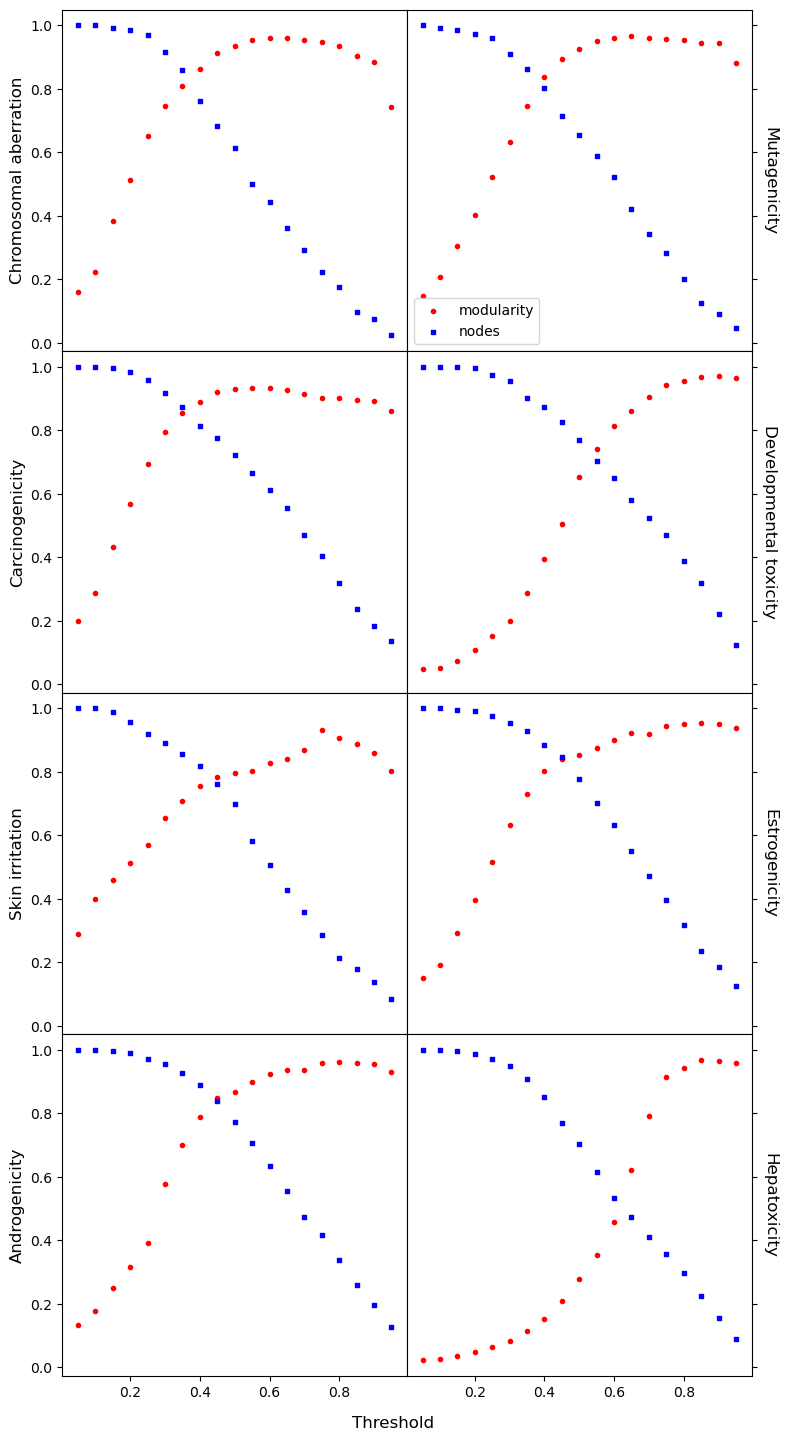

In [12]:
fig, plots = plt.subplots(ncols=2, nrows=4,
                          # figsize=(8,8),
                          sharex=True, sharey=True,
                         gridspec_kw={"wspace":.0, "hspace":.0}
                         )
for i,(endpoint, plot) in enumerate(zip(dictEndpoint, plots.flatten())):
    df = commFiles[endpoint]
    # plot.grid(visible=True, axis="x")
    plot.scatter(*df[["thr","modularity"]].T.values, color = "red", s=9, label = "modularity")
    plot.scatter(*df[["thr","survivedNorm"]].T.values, marker="s", color = "blue", s=9, label="nodes")

    if i%2 == 1:
        plot.yaxis.tick_right()
        plot.yaxis.set_label_position("right")
        plot.set_ylabel(dictEndpoint[endpoint], rotation = 270, va="bottom")
    else:
        plot.set_ylabel(dictEndpoint[endpoint])
    
    # plot.set_xlabel("Threshold")

plots[0,1].legend()
fig.supxlabel("Threshold")
fig.tight_layout()

In [15]:
fig.savefig("Figures/figure_surv_nodes.pdf", bbox_inches = "tight")

# Embedding

In [13]:
embDir = "embeddings"
embFiles = { file.split("_")[0] :  pd.read_csv(f"{embDir}/{file}")
             for file in os.listdir(embDir) if ".csv" in file and not "epoch0" in file }

emb0Files = { file.split("_")[0] :  pd.read_csv(f"{embDir}/{file}")
             for file in os.listdir(embDir) if ".csv" in file and "epoch0" in file }

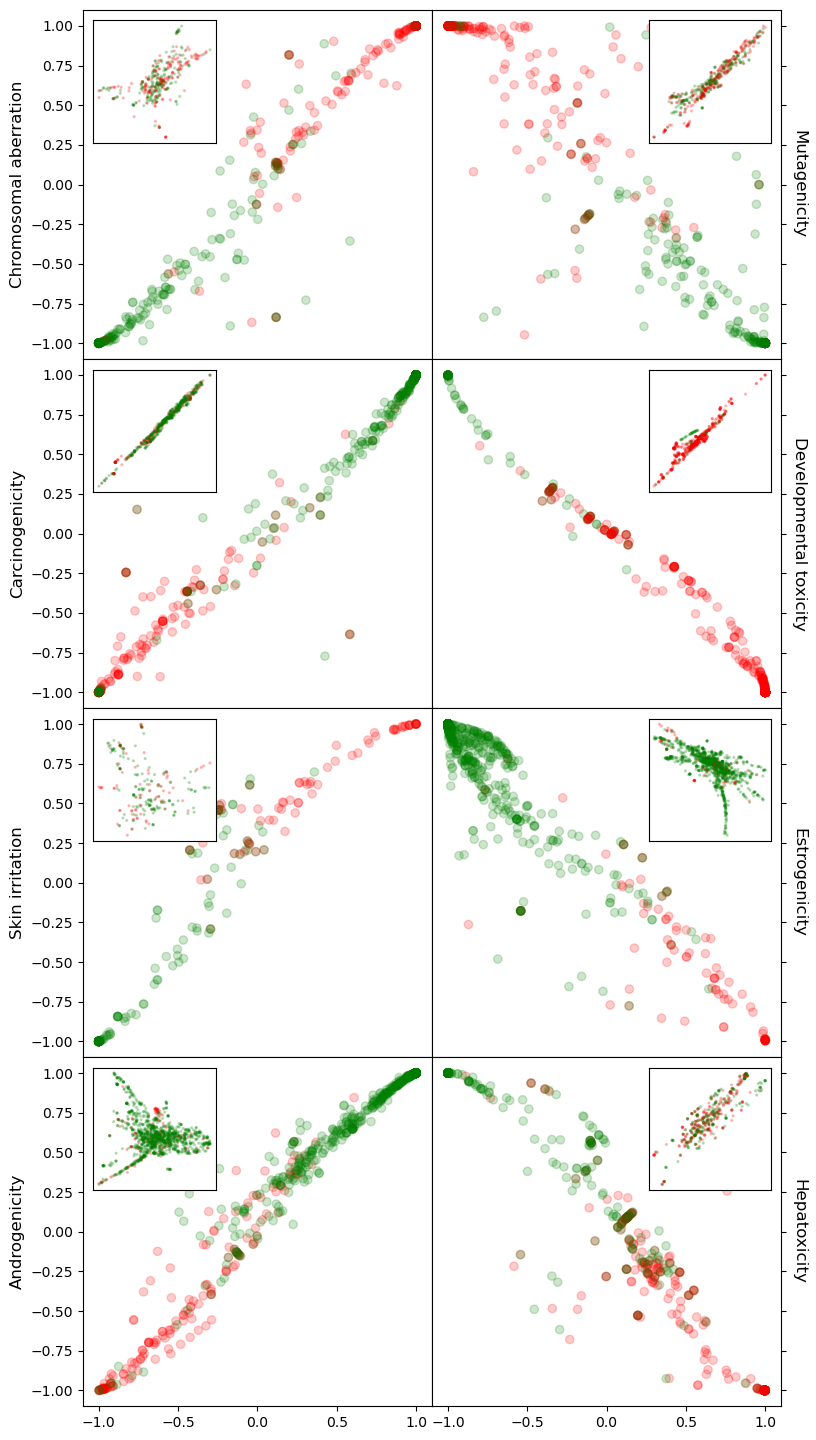

In [14]:
colorDict={1:"red", 0:"green"}
size = .35,.35
insetPosDict={
                "topLeft":[.03,.62,*size], "topRight":[.62,.62,*size], 
                "bottomLeft":[.03,.03,*size], "bottomRight":[.62,.03,*size],
            }

insetPos = ["topRight","bottomLeft","bottomRight","topRight","topLeft","bottomRight","topLeft","topRight"]
fig, plots = plt.subplots(ncols=2, nrows=4,
                          # figsize=(8,8),
                          sharex=True, sharey=True,
                         gridspec_kw={"wspace":.0, "hspace":.0},
                         )

for i,(endpoint, plot) in enumerate(zip(dictEndpoint, plots.flatten())):
    
    embs = embFiles[endpoint]
    embs0 = emb0Files[endpoint]
    y = Yfilt[endpoint]
    color = y.apply(colorDict.get)

    if endpoint in ["carcino","muta"]:
        # Invert slope of embedding line just for a better view of figure...
        x,y = embs.T.values
        plot.scatter(x,y*(-1), c=color, alpha=0.2)
    else:
        plot.scatter(*embs.T.values, c=color, alpha=0.2)
        
    plot.set(adjustable='box', aspect='equal')

    if i%2 == 1:
        plot.yaxis.tick_right()
        plot.yaxis.set_label_position("right")
        plot.set_ylabel(dictEndpoint[endpoint], rotation = 270, va="bottom")
        posIns = "topRight"
    else:
        plot.set_ylabel(dictEndpoint[endpoint])
        posIns="topLeft"
    

    axins = plot.inset_axes(
        # insetPosDict[insetPos[i]], 
        insetPosDict[posIns],
        xticklabels=[], yticklabels=[], yticks=[], xticks=[])
    
    axins.scatter(*embs0.T.values, c=color, alpha=0.2, s=2.0)
    # axins.set_xlim(-1,1)
    # axins.set_ylim(-1,1)
    # axins.set_aspect('equal')

fig.tight_layout()

In [15]:
fig.savefig("Figures/figure_embedding_examplesv.pdf", bbox_inches = "tight")

# Internal similarity

In [37]:
adjDir="adj"
adjs = { endpoint : pd.read_csv(f"{adjDir}/{endpoint}.txt", header=None, sep=" ").iloc[molIdxs,molIdxs] 
        for endpoint,molIdxs in idxs.items() }

In [38]:
def getTriangleMatrix(arr):
    shape=len(arr)
    return arr[np.triu_indices(shape)]

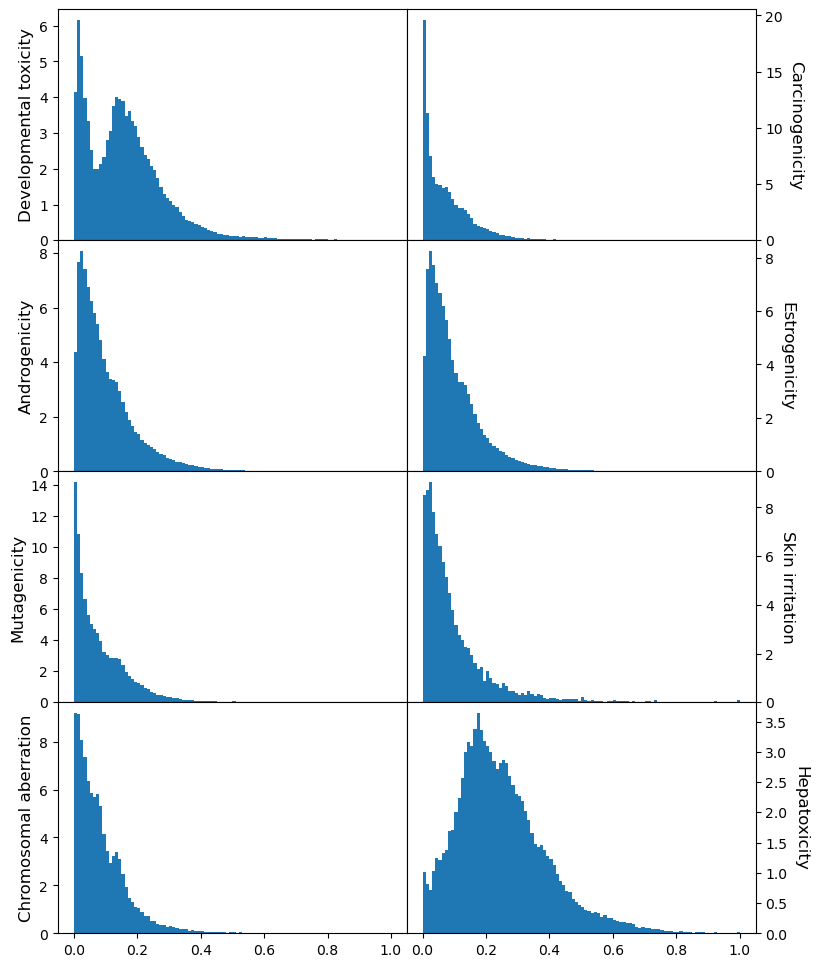

In [40]:
fig, plots = plt.subplots(ncols=2, nrows=4,
                          # figsize=(8,8),
                          sharex=True,
                         gridspec_kw={"wspace":.0, "hspace":.0},
                         )

for i,(endpoint, plot) in enumerate(zip(dictEndpoint, plots.flatten())):
    triangle = getTriangleMatrix(adjs[endpoint].values)
    plot.hist(triangle, bins=100, density=True)

    if i%2 == 1:
        plot.yaxis.tick_right()
        plot.yaxis.set_label_position("right")
        plot.set_ylabel(dictEndpoint[endpoint], rotation = 270, va="bottom")
    else:
        plot.set_ylabel(dictEndpoint[endpoint])

# ROC Curve

In [16]:
def alignPredScore(name, dir):
    path = f"{dir}/{name}"
    endpoint,*_ = name.split("_")
    labels = Yfilt[endpoint].values
    scoresDF = pd.read_csv(path)
    scoresMean = scoresDF.mean(axis=1)
    scores = scoresMean.dropna().values
    mask = scoresMean.notna()
    y = labels[mask]

    return endpoint, np.array([y,scores])

In [17]:
dirKNN = "scoresCV_KNN"
rocKNN = dict( alignPredScore(file.name, dirKNN)  for file in os.scandir(dirKNN) if ".csv" in file.name )

In [18]:
dirGCN = "scoresCV"
rocGCN = dict( alignPredScore(file.name, dirGCN)  for file in os.scandir(dirGCN) if ".csv" in file.name )

In [19]:
resultsKNN = pd.read_csv("Tables/knnMetrics.csv", index_col=[0,1,2,3], header=[0,1])
resultsGCN = pd.read_csv("Tables/gcnMetrics.csv", index_col=[0,1,2,3,4,5,6], header=[0,1])

In [20]:
from sklearn import metrics

In [21]:
legendsKNN = {"andro":"0.65 ± 0.08",
             "carcino":"0.65 ± 0.08",
             "chrom":"0.58 ± 0.10",
             "devtox":"0.62 ± 0.14",
             "estro":"0.62 ± 0.14",
             "hepa":"0.56 ± 0.10",
             "muta":"0.63 ± 0.08",
             "skin":"0.56 ± 0.14"}

In [22]:
legendsGCN = {"andro":"0.81 ± 0.05",
             "carcino":"0.81 ± 0.06",
             "chrom":"0.64 ± 0.09",
             "devtox":"0.70 ± 0.11",
             "estro":"0.83 ± 0.08",
             "hepa":"0.64 ± 0.08",
             "muta":"0.73 ± 0.06",
             "skin":"0.65 ± 0.12"}

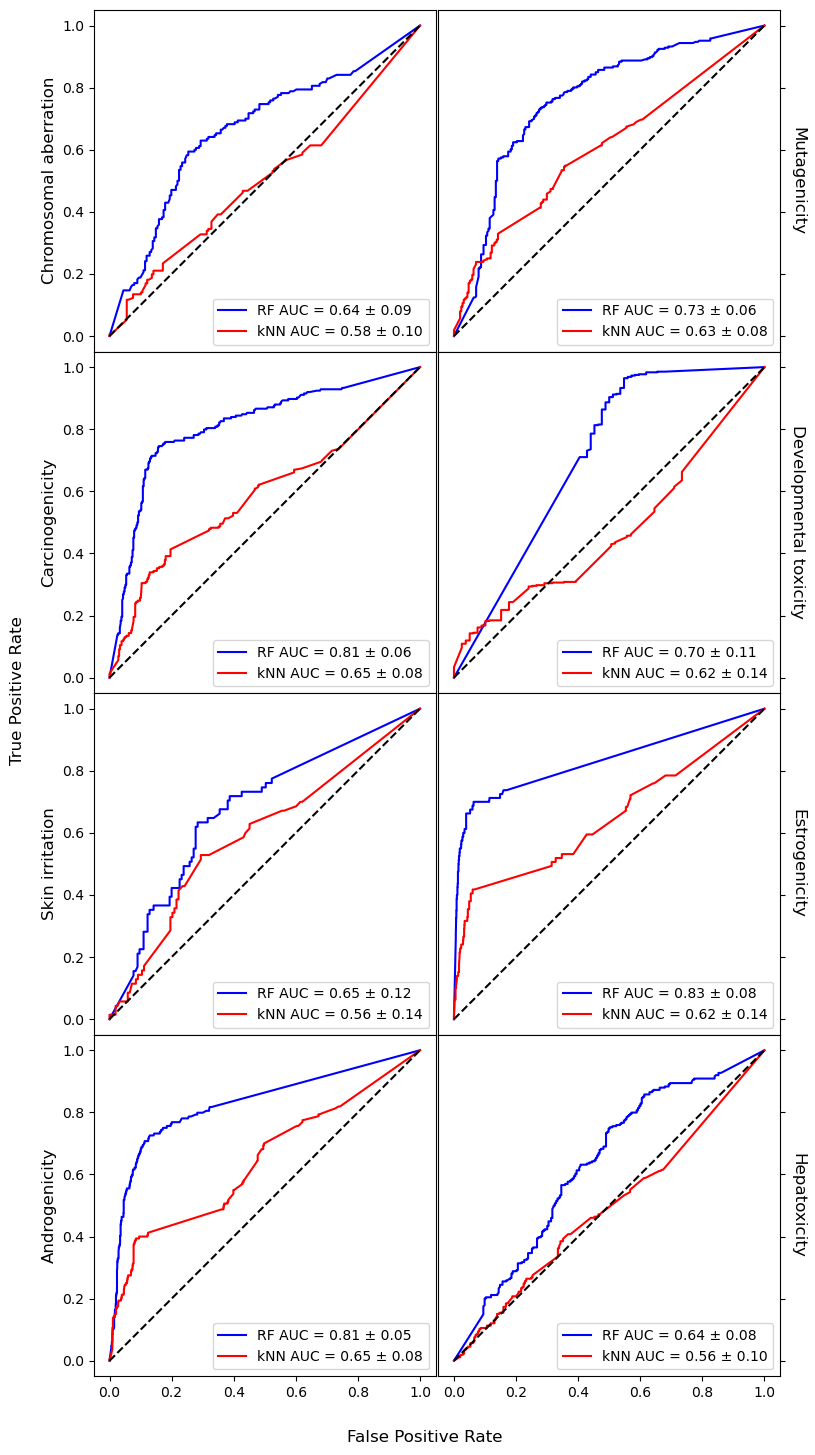

In [23]:
fig, plots = plt.subplots(ncols=2, nrows=4,
                          sharex=True, sharey=True,
                         gridspec_kw={"wspace":.0, "hspace":.0},
                         )

for i,(endpoint, plot) in enumerate(zip(dictEndpoint, plots.flatten() )):
    fprGCN, tprGCN, _ = metrics.roc_curve(*rocGCN[endpoint])
    plot.plot(fprGCN, tprGCN,label="RF AUC = "+legendsGCN[endpoint], color="blue")

    fprKNN, tprKNN, _ = metrics.roc_curve(*rocKNN[endpoint])
    plot.plot(fprKNN, tprKNN,label="kNN AUC = "+legendsKNN[endpoint], color="red")
        
    if i%2 == 1:
        plot.yaxis.tick_right()
        plot.yaxis.set_label_position("right")
        plot.set_ylabel(dictEndpoint[endpoint], rotation = 270, va="bottom")
    else:
        plot.set_ylabel(dictEndpoint[endpoint])
        
    plot.set(adjustable='box', aspect='equal')


    plot.legend(loc="lower right")
    plot.plot([0,1],[0,1], color = "black",ls="dashed")


fig.supylabel("True Positive Rate", x=0,y=.52)
fig.supxlabel("False Positive Rate", y =0, x=.52)
fig.tight_layout()

In [24]:
# fig.savefig("Figures/auc_v.png",bbox_inches="tight")
fig.savefig("Figures/auc_v.pdf",bbox_inches="tight")

# Score Toxicity

In [24]:
scoreAbsence=pd.read_csv("Tables/scoreAbsence.csv")
scorePresence=pd.read_csv("Tables/scorePresence.csv")

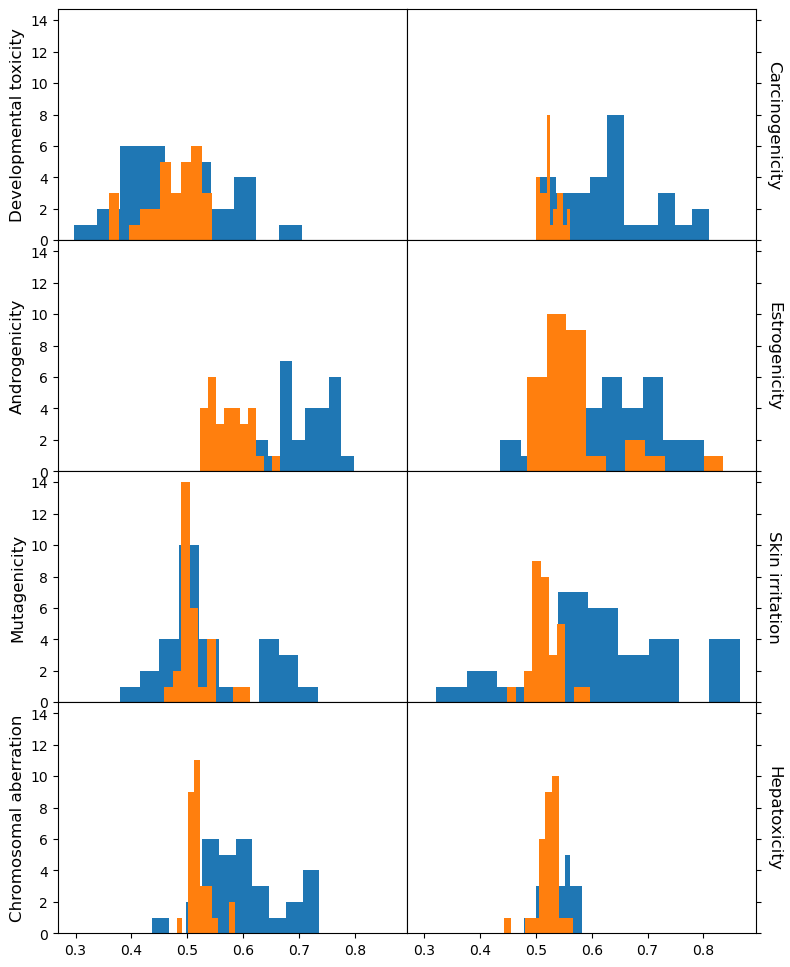

In [56]:
fig, plots = plt.subplots(ncols=2, nrows=4,
                          # figsize=(8,8),
                          sharex=True, sharey=True,
                         gridspec_kw={"wspace":.0, "hspace":.0},
                         )

for i,(endpoint, plot) in enumerate(zip(dictEndpoint, plots.flatten())):
    plot.hist(scorePresence[endpoint], bins = 10)
    plot.hist(scoreAbsence[endpoint], bins = 10)

    if i%2 == 1:
        plot.yaxis.tick_right()
        plot.yaxis.set_label_position("right")
        plot.set_ylabel(dictEndpoint[endpoint], rotation = 270, va="bottom")
    else:
        plot.set_ylabel(dictEndpoint[endpoint])

# Toxicity Bits

In [86]:
scoreAbsence=pd.read_csv("Tables/scoreAbsence.csv")
scorePresence=pd.read_csv("Tables/scorePresence.csv")

In [87]:
fpDir = "FPs"
Xs = {endpoint: pd.read_csv(f"{fpDir}/{endpoint}_FP.csv", header=None).iloc[idxs[endpoint]]
    for endpoint in dictEndpoint
}

In [88]:
bitsSorted = pd.read_csv("Tables/bitsImportance.csv")

In [89]:
from rdkit.Chem import AllChem
from rdkit import Chem

In [90]:
fpgen = AllChem.GetRDKitFPGenerator()
def getImgsForEndpoint(endpoint, bits):

    smi = smisfilt[endpoint]
    label = Yfilt[endpoint]
    # print(coeffs[endpoint]["coef1"].loc[idxs])
    Xtmp = Xs[endpoint]

    mols = smi.apply(Chem.MolFromSmiles)
    maskBitOn=Xtmp.map(bool)

    def getImg(idxBit, idxMol = 0):
        ao = AllChem.AdditionalOutput()
        ao.CollectBitPaths()
        mol=mols[ maskBitOn[idxBit] ].values[idxMol]
        # print(smi[maskBitOn[idxBit]].values[idxMol])
        fp = fpgen.GetFingerprint(mol,additionalOutput=ao)
        rdkbi = ao.GetBitPaths()
        example = np.argmax( [ len(i) for i in rdkbi[idxBit] ])
        rdk_svg = Chem.Draw.DrawRDKitBit(mol, idxBit, rdkbi, whichExample=example, useSVG=False)
        return rdk_svg

    return [ getImg(i) for i in bits ]

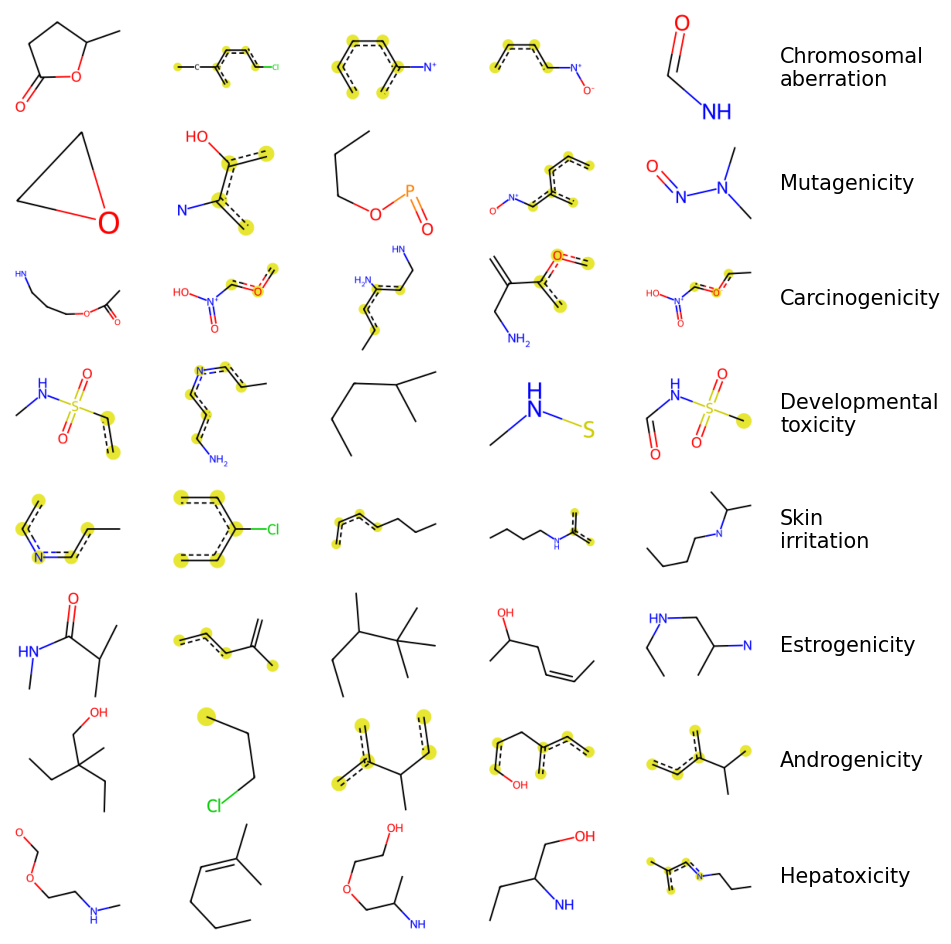

In [91]:
maxBits = 5
fig, axes = plt.subplots(nrows=len(dictEndpoint), ncols=maxBits, gridspec_kw={'hspace': 0.0001, 'wspace':0.1}, figsize = (10,12)
                        )

for row,endpoint in zip(axes, dictEndpoint):

    tmpEndpointName = dictEndpoint[endpoint]
    bitToxEndpoint = bitsSorted[tmpEndpointName][:maxBits]
    imgs = getImgsForEndpoint(endpoint, bitToxEndpoint)
    
    scoreEndpoint = scorePresence.loc[:maxBits,endpoint].values
    row[0].set_ylabel(endpoint)
    
    i=0
    
    for col, img, width in zip(row, imgs, scoreEndpoint):
        
        col.imshow(img)
        
        xmin,xmax = col.get_xlim()
        ymin,ymax = col.get_ylim()
        height = (ymin-ymax)*0.12
        where = ymin+height/2

        
        # col.barh(where, width = xmax, height=height, clip_on = False, color="green", align="center")
        # col.barh(where, width = xmax*width, height=height, clip_on = False, color="red", align="center")
        col.axis("off")
        
    col.text(xmax+(xmax-xmin)*.2, (ymin-ymax)/2, dictEndpoint[endpoint].replace(" ","\n"), fontsize = 15, va="center")

#fig.tight_layout()

In [92]:
fig.savefig("Figures/figure_toxBits.pdf", bbox_inches="tight")